In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import trange, tqdm
import os

In [40]:
TRAIN_DIR = 'data/VGG-Face2/data/vggface2_train/train'
TEST_DIR = 'data/VGG-Face2/data/vggface2_test/test'
IMG_SIZE = 128
BATCH_SIZE = 512
LR = 1E-3
EPOCHS = 10

In [ ]:
def load_custom_data(train_dir, test_dir, batch_size=64):
    """
    Load custom dataset with separate train and test directories.
    :param train_dir: Path to the training dataset directory.
    :param test_dir: Path to the testing dataset directory.
    :param batch_size: Number of samples per batch.
    :return: train_loader, test_loader
    """
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])

    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, len(train_dataset.classes)

In [28]:
train_loader, test_loader, num_classes = load_custom_data(TRAIN_DIR, TEST_DIR, BATCH_SIZE)

In [29]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([512, 3, 128, 128]) torch.Size([512])


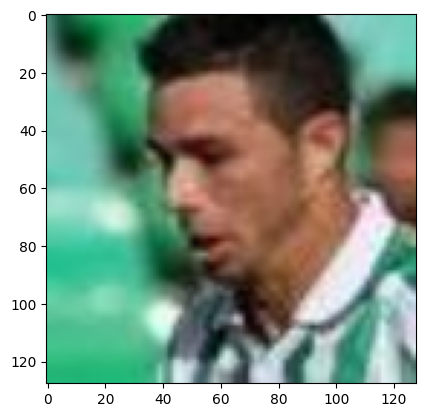

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((x[0].permute(1, 2, 0) + 1) / 2) # [-1, 1] -> [0, 1] and permute to (H, W, C) for plotting

In [31]:
x.min(), x.max(), x.mean(), x.std()

(tensor(-1.), tensor(1.), tensor(-0.1615), tensor(0.5673))

In [42]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * IMG_SIZE * IMG_SIZE, 128), # 64 * IMG_SIZE/4 * IMG_SIZE/4
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Number of classes in the dataset
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [44]:
model = CNN(num_classes=num_classes)
model.to(device)
# number of parameters in the model
sum(p.numel() for p in model.parameters() if p.requires_grad)

9521527

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [46]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total


    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print("=" * 50)

  0%|          | 5/6137 [01:07<22:50:17, 13.41s/it]


KeyboardInterrupt: 